# =============================================================================
# CYCLISTIC BIKE SHARE DATA ANALYSIS - COMPLETE PROCESSING NOTEBOOK
# January - August 2024 (8 Months) - Clean Dataset Creation
# =============================================================================

"""
BUSINESS QUESTION: How do annual members and casual riders use Cyclistic bikes differently?
GOAL: Convert casual riders to annual members

This notebook processes the complete clean dataset covering 8 months of 2024:
✅ Jan-Aug 2024: ALL files verified clean (969.7 MB total data)
❌ Sep-Dec 2024: Corrupted timestamp formatting (optional for future analysis)

COVERAGE ANALYSIS:
• Complete seasonal transition: Winter → Spring → Summer
• Peak casual ridership period included (Jun-Aug critical for conversion insights)
• Strong statistical power: ~8 months of bike-share data
• Sufficient for robust business recommendations

This notebook:
1. Processes all 8 clean monthly files (Jan-Aug 2024)
2. Applies consistent data cleaning and quality standards
3. Creates comprehensive feature engineering
4. Combines into complete analysis-ready dataset
5. Provides business-focused data validation

Data Sources: Divvy System Data (Chicago bike-share representing Cyclistic);
Processing Tool: Python with pandas in Google Colab
"""

In [3]:
# =============================================================================
# 1. SETUP AND IMPORTS
# =============================================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("🚴‍♂️ CYCLISTIC DATA PROCESSING - COMPLETE DATASET")
print("="*60)
print(f"Processing started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚴‍♂️ CYCLISTIC DATA PROCESSING - COMPLETE DATASET
Processing started: 2025-09-28 15:22:05



In [4]:
# =============================================================================
# 2. DEFINE PATHS AND CONSTANTS
# =============================================================================

# Project paths
BASE_PATH = '/content/drive/MyDrive/Cyclistic_Capstone_Project'
RAW_DATA_PATH = f'{BASE_PATH}/01_Data/01_raw'
PROCESSED_DATA_PATH = f'{BASE_PATH}/01_Data/02_processed'

# Existing clean data file
EXISTING_CLEAN_FILE = f'{PROCESSED_DATA_PATH}/cyclistic_2024_jan_may_clean.csv'

# All clean monthly files (verified via diagnostic)
CLEAN_MONTHLY_FILES = [
    '202401-divvy-tripdata.csv',  # January 2024
    '202402-divvy-tripdata.csv',  # February 2024
    '202403-divvy-tripdata.csv',  # March 2024
    '202404-divvy-tripdata.csv',  # April 2024
    '202405-divvy-tripdata.csv',  # May 2024
    '202406-divvy-tripdata.csv',  # June 2024
    '202407-divvy-tripdata.csv',  # July 2024
    '202408-divvy-tripdata.csv'   # August 2024
]

# Geographic bounds for Chicago (for data quality filtering)
CHICAGO_BOUNDS = {
    'lat_min': 41.64,
    'lat_max': 42.02,
    'lng_min': -87.94,
    'lng_max': -87.52
}

# Data quality parameters
MIN_RIDE_LENGTH = 1      # minimum 1 minute
MAX_RIDE_LENGTH = 1440   # maximum 24 hours
CHUNK_SIZE = 100000      # for memory-efficient processing

print(f"📁 Raw data path: {RAW_DATA_PATH}")
print(f"📁 Processed data path: {PROCESSED_DATA_PATH}")
print(f"📊 Clean monthly files: {len(CLEAN_MONTHLY_FILES)} months (Jan-Aug 2024)")
print(f"📈 Expected dataset size: ~970 MB raw data")
print()

📁 Raw data path: /content/drive/MyDrive/Cyclistic_Capstone_Project/01_Data/01_raw
📁 Processed data path: /content/drive/MyDrive/Cyclistic_Capstone_Project/01_Data/02_processed
📊 Clean monthly files: 8 months (Jan-Aug 2024)
📈 Expected dataset size: ~970 MB raw data



In [5]:
# =============================================================================
# 3. PROCESS ALL CLEAN MONTHLY FILES (JAN-AUG 2024)
# =============================================================================

print("📊 PROCESSING COMPLETE 8-MONTH DATASET (JAN-AUG 2024)")
print("-" * 60)
print("✅ Processing strategy: Fresh processing of all 8 clean months")
print("📅 Coverage: Complete seasonal transition (Winter → Spring → Summer)")
print("🎯 Business focus: Peak casual ridership period for conversion insights")
print()

def clean_monthly_data(df_month, month_name):
    """
    Apply consistent cleaning to monthly data
    """
    print(f"  🧹 Cleaning {month_name} data...")
    initial_count = len(df_month)

    # 1. Remove duplicates
    df_month = df_month.drop_duplicates()
    after_duplicates = len(df_month)

    # 2. Remove rows with missing critical data
    critical_columns = ['ride_id', 'started_at', 'ended_at', 'member_casual']
    df_month = df_month.dropna(subset=critical_columns)
    after_missing = len(df_month)

    # 3. Convert datetime columns
    df_month['started_at'] = pd.to_datetime(df_month['started_at'])
    df_month['ended_at'] = pd.to_datetime(df_month['ended_at'])

    # 4. Calculate ride length in minutes
    df_month['ride_length_minutes'] = (df_month['ended_at'] - df_month['started_at']).dt.total_seconds() / 60

    # 5. Filter by ride length (1 minute to 24 hours)
    df_month = df_month[
        (df_month['ride_length_minutes'] >= MIN_RIDE_LENGTH) &
        (df_month['ride_length_minutes'] <= MAX_RIDE_LENGTH)
    ]
    after_duration = len(df_month)

    # 6. Filter by geographic bounds (if coordinates available)
    if all(col in df_month.columns for col in ['start_lat', 'start_lng']):
        df_month = df_month[
            (df_month['start_lat'].between(CHICAGO_BOUNDS['lat_min'], CHICAGO_BOUNDS['lat_max'])) &
            (df_month['start_lng'].between(CHICAGO_BOUNDS['lng_min'], CHICAGO_BOUNDS['lng_max']))
        ]
        after_geo = len(df_month)
    else:
        after_geo = after_duration

    # 7. Create additional features
    df_month['day_of_week'] = df_month['started_at'].dt.day_name()
    df_month['hour'] = df_month['started_at'].dt.hour
    df_month['date'] = df_month['started_at'].dt.date
    df_month['month'] = df_month['started_at'].dt.month
    df_month['is_weekend'] = df_month['started_at'].dt.weekday.isin([5, 6])

    # Print cleaning summary
    print(f"    📊 {month_name} cleaning summary:")
    print(f"      Initial records: {initial_count:,}")
    print(f"      After duplicates: {after_duplicates:,} (-{initial_count-after_duplicates:,})")
    print(f"      After missing data: {after_missing:,} (-{after_duplicates-after_missing:,})")
    print(f"      After duration filter: {after_duration:,} (-{after_missing-after_duration:,})")
    print(f"      After geographic filter: {after_geo:,} (-{after_duration-after_geo:,})")
    print(f"      ✅ Final clean records: {after_geo:,}")

    return df_month

# Process each month
monthly_dataframes = []
total_records = 0
monthly_summary = {}

for filename in CLEAN_MONTHLY_FILES:
    file_path = os.path.join(RAW_DATA_PATH, filename)
    month_name = filename[4:6]  # Extract MM from YYYYMM
    month_display = {'01':'Jan', '02':'Feb', '03':'Mar', '04':'Apr', '05':'May', '06':'Jun',
                     '07':'Jul', '08':'Aug'}.get(month_name, month_name)

    print(f"📊 Processing: {month_display} 2024 ({filename})")

    try:
        # Read the file in chunks for memory efficiency
        chunk_list = []
        for chunk in pd.read_csv(file_path, chunksize=CHUNK_SIZE):
            chunk_list.append(chunk)

        # Combine chunks
        df_month = pd.concat(chunk_list, ignore_index=True)
        print(f"  📁 Loaded {len(df_month):,} raw records")

        # Clean the monthly data
        df_month_clean = clean_monthly_data(df_month, f"{month_display} 2024")

        # Add to collection
        monthly_dataframes.append(df_month_clean)
        total_records += len(df_month_clean)
        monthly_summary[month_display] = {
            'raw_records': len(df_month),
            'clean_records': len(df_month_clean),
            'cleaning_efficiency': (len(df_month_clean) / len(df_month)) * 100
        }

    except Exception as e:
        print(f"  ❌ Error processing {filename}: {e}")
        continue

    print()

print(f"🎉 COMPLETE PROCESSING SUMMARY:")
print(f"   📊 Total clean records: {total_records:,}")
print(f"   📅 Months processed: {len(monthly_dataframes)}/8")
print(f"   📈 Monthly breakdown:")
for month, stats in monthly_summary.items():
    print(f"     {month}: {stats['clean_records']:,} records ({stats['cleaning_efficiency']:.1f}% retention)")

print("\n" + "="*60 + "\n")

📊 PROCESSING COMPLETE 8-MONTH DATASET (JAN-AUG 2024)
------------------------------------------------------------
✅ Processing strategy: Fresh processing of all 8 clean months
📅 Coverage: Complete seasonal transition (Winter → Spring → Summer)
🎯 Business focus: Peak casual ridership period for conversion insights

📊 Processing: Jan 2024 (202401-divvy-tripdata.csv)
  📁 Loaded 144,873 raw records
  🧹 Cleaning Jan 2024 data...
    📊 Jan 2024 cleaning summary:
      Initial records: 144,873
      After duplicates: 144,873 (-0)
      After missing data: 144,873 (-0)
      After duration filter: 142,038 (-2,835)
      After geographic filter: 140,444 (-1,594)
      ✅ Final clean records: 140,444

📊 Processing: Feb 2024 (202402-divvy-tripdata.csv)
  📁 Loaded 223,164 raw records
  🧹 Cleaning Feb 2024 data...
    📊 Feb 2024 cleaning summary:
      Initial records: 223,164
      After duplicates: 223,164 (-0)
      After missing data: 223,164 (-0)
      After duration filter: 220,480 (-2,684)
  

In [6]:
# =============================================================================
# 4. COMBINE COMPLETE 8-MONTH DATASET
# =============================================================================

print("🔗 COMBINING COMPLETE 8-MONTH DATASET (JAN-AUG 2024)")
print("-" * 60)

if monthly_dataframes:
    # Combine all monthly dataframes
    df_complete = pd.concat(monthly_dataframes, ignore_index=True)
    print(f"🎉 COMPLETE DATASET CREATED: {len(df_complete):,} total records")

    # Comprehensive data validation
    print(f"📅 Complete date range: {df_complete['started_at'].min()} to {df_complete['started_at'].max()}")
    print(f"👥 User distribution: {df_complete['member_casual'].value_counts().to_dict()}")

    # Seasonal analysis preview
    print(f"📊 Monthly distribution:")
    monthly_counts = df_complete.groupby('month').size().sort_index()
    month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    for month, count in monthly_counts.items():
        if month <= 8:  # Only show our processed months
            pct_casual = (df_complete[(df_complete['month'] == month) &
                                    (df_complete['member_casual'] == 'casual')].shape[0] / count) * 100
            print(f"      {month_names[month]}: {count:,} trips ({pct_casual:.1f}% casual)")

else:
    print("❌ No data available to combine")
    df_complete = pd.DataFrame()

print("\n" + "="*60 + "\n")

🔗 COMBINING COMPLETE 8-MONTH DATASET (JAN-AUG 2024)
------------------------------------------------------------
🎉 COMPLETE DATASET CREATED: 3,799,262 total records
📅 Complete date range: 2024-01-01 00:00:00 to 2024-08-31 23:58:13.586000
👥 User distribution: {'member': 2399781, 'casual': 1399481}
📊 Monthly distribution:
      Jan: 140,444 trips (16.7% casual)
      Feb: 218,331 trips (20.9% casual)
      Mar: 294,895 trips (27.2% casual)
      Apr: 403,968 trips (31.5% casual)
      May: 593,574 trips (37.6% casual)
      Jun: 687,768 trips (41.8% casual)
      Jul: 727,061 trips (42.2% casual)
      Aug: 733,221 trips (41.6% casual)




In [7]:
# =============================================================================
# 5. FINAL DATA QUALITY CHECK
# =============================================================================

print("🔍 FINAL DATA QUALITY CHECK")
print("-" * 50)

if not df_complete.empty:
    print(f"📊 Dataset shape: {df_complete.shape}")
    print(f"🗂️ Columns: {list(df_complete.columns)}")

    # Check for missing values
    print(f"\n🔍 Missing values check:")
    missing_summary = df_complete.isnull().sum()
    for col, missing_count in missing_summary.items():
        if missing_count > 0:
            pct = (missing_count / len(df_complete)) * 100
            print(f"  {col}: {missing_count:,} ({pct:.1f}%)")

    # Data type summary
    print(f"\n📋 Data types:")
    for col, dtype in df_complete.dtypes.items():
        print(f"  {col}: {dtype}")

    # Key statistics
    print(f"\n📈 Key statistics:")
    print(f"  Average ride length: {df_complete['ride_length_minutes'].mean():.1f} minutes")
    print(f"  Median ride length: {df_complete['ride_length_minutes'].median():.1f} minutes")
    print(f"  Weekend trips: {df_complete['is_weekend'].sum():,} ({df_complete['is_weekend'].mean()*100:.1f}%)")

    # Member vs casual breakdown
    member_stats = df_complete.groupby('member_casual').agg({
        'ride_length_minutes': ['mean', 'median', 'count']
    }).round(1)
    print(f"\n👥 User type comparison:")
    print(member_stats)

print("\n" + "="*60 + "\n")

🔍 FINAL DATA QUALITY CHECK
--------------------------------------------------
📊 Dataset shape: (3799262, 19)
🗂️ Columns: ['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual', 'ride_length_minutes', 'day_of_week', 'hour', 'date', 'month', 'is_weekend']

🔍 Missing values check:
  start_station_name: 640,927 (16.9%)
  start_station_id: 640,927 (16.9%)
  end_station_name: 647,005 (17.0%)
  end_station_id: 647,005 (17.0%)

📋 Data types:
  ride_id: object
  rideable_type: object
  started_at: datetime64[ns]
  ended_at: datetime64[ns]
  start_station_name: object
  start_station_id: object
  end_station_name: object
  end_station_id: object
  start_lat: float64
  start_lng: float64
  end_lat: float64
  end_lng: float64
  member_casual: object
  ride_length_minutes: float64
  day_of_week: object
  hour: int32
  date: object
  month: int32
  is_weeken

In [8]:
# =============================================================================
# 6. SAVE COMPLETE DATASET
# =============================================================================

print("💾 SAVING COMPLETE DATASET")
print("-" * 50)

if not df_complete.empty:
    # Create output filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    output_filename = f'cyclistic_2024_jan_aug_complete_{timestamp}.csv'
    output_path = os.path.join(PROCESSED_DATA_PATH, output_filename)

    try:
        # Save as CSV
        df_complete.to_csv(output_path, index=False)
        print(f"✅ Complete dataset saved: {output_filename}")
        print(f"📁 Location: {output_path}")
        print(f"📊 Records saved: {len(df_complete):,}")

        # Also save as Parquet for faster loading (if needed)
        parquet_filename = f'cyclistic_2024_jan_aug_complete_{timestamp}.parquet'
        parquet_path = os.path.join(PROCESSED_DATA_PATH, parquet_filename)
        df_complete.to_parquet(parquet_path, index=False)
        print(f"✅ Parquet version saved: {parquet_filename}")

        # Create a "latest" version for easy reference
        latest_csv = os.path.join(PROCESSED_DATA_PATH, 'cyclistic_2024_complete_latest.csv')
        latest_parquet = os.path.join(PROCESSED_DATA_PATH, 'cyclistic_2024_complete_latest.parquet')
        df_complete.to_csv(latest_csv, index=False)
        df_complete.to_parquet(latest_parquet, index=False)
        print(f"✅ Latest versions created for easy access")

    except Exception as e:
        print(f"❌ Error saving dataset: {e}")
else:
    print("❌ No data to save")

print("\n" + "="*60 + "\n")

💾 SAVING COMPLETE DATASET
--------------------------------------------------
✅ Complete dataset saved: cyclistic_2024_jan_aug_complete_20250928_1531.csv
📁 Location: /content/drive/MyDrive/Cyclistic_Capstone_Project/01_Data/02_processed/cyclistic_2024_jan_aug_complete_20250928_1531.csv
📊 Records saved: 3,799,262
✅ Parquet version saved: cyclistic_2024_jan_aug_complete_20250928_1531.parquet
✅ Latest versions created for easy access




In [9]:
# =============================================================================
# 7. PROCESSING SUMMARY
# =============================================================================

print("📋 PROCESSING SUMMARY")
print("-" * 50)

if not df_complete.empty:
    print(f"🎯 BUSINESS QUESTION: How do annual members and casual riders use Cyclistic bikes differently?")
    print()
    print(f"✅ DATA PROCESSING COMPLETE")
    print(f"   📅 Time period: January - August 2024 (8 months)")
    print(f"   📊 Total clean records: {len(df_complete):,}")
    print(f"   🗂️ Features created: {len(df_complete.columns)} columns")
    print()

    # Seasonal insights preview
    seasonal_summary = df_complete.groupby(['month', 'member_casual']).size().unstack(fill_value=0)
    print(f"🌟 SEASONAL PATTERNS PREVIEW:")
    print(seasonal_summary)
    print()

    casual_pct_by_month = (seasonal_summary['casual'] / seasonal_summary.sum(axis=1) * 100).round(1)
    print(f"📈 Casual rider percentage by month:")
    month_names = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
    for month in casual_pct_by_month.index:
        print(f"   {month_names[month]}: {casual_pct_by_month[month]}% casual")

    print()
    print(f"🎯 READY FOR ANALYSIS PHASE!")
    print(f"   • Complete seasonal data including summer peak")
    print(f"   • Strong casual rider representation for conversion insights")
    print(f"   • Clean, analysis-ready dataset with engineered features")

else:
    print("❌ Processing failed - no data available for analysis")

print()
print(f"⏰ Processing completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

📋 PROCESSING SUMMARY
--------------------------------------------------
🎯 BUSINESS QUESTION: How do annual members and casual riders use Cyclistic bikes differently?

✅ DATA PROCESSING COMPLETE
   📅 Time period: January - August 2024 (8 months)
   📊 Total clean records: 3,799,262
   🗂️ Features created: 19 columns

🌟 SEASONAL PATTERNS PREVIEW:
member_casual  casual  member
month                        
1               23448  116996
2               45648  172683
3               80152  214743
4              127243  276725
5              223140  370434
6              287623  400145
7              307091  419970
8              305136  428085

📈 Casual rider percentage by month:
   Jan: 16.7% casual
   Feb: 20.9% casual
   Mar: 27.2% casual
   Apr: 31.5% casual
   May: 37.6% casual
   Jun: 41.8% casual
   Jul: 42.2% casual
   Aug: 41.6% casual

🎯 READY FOR ANALYSIS PHASE!
   • Complete seasonal data including summer peak
   • Strong casual rider representation for conversion insights
   • C


📊 QUICK DATA VERIFICATION PLOTS
--------------------------------------------------


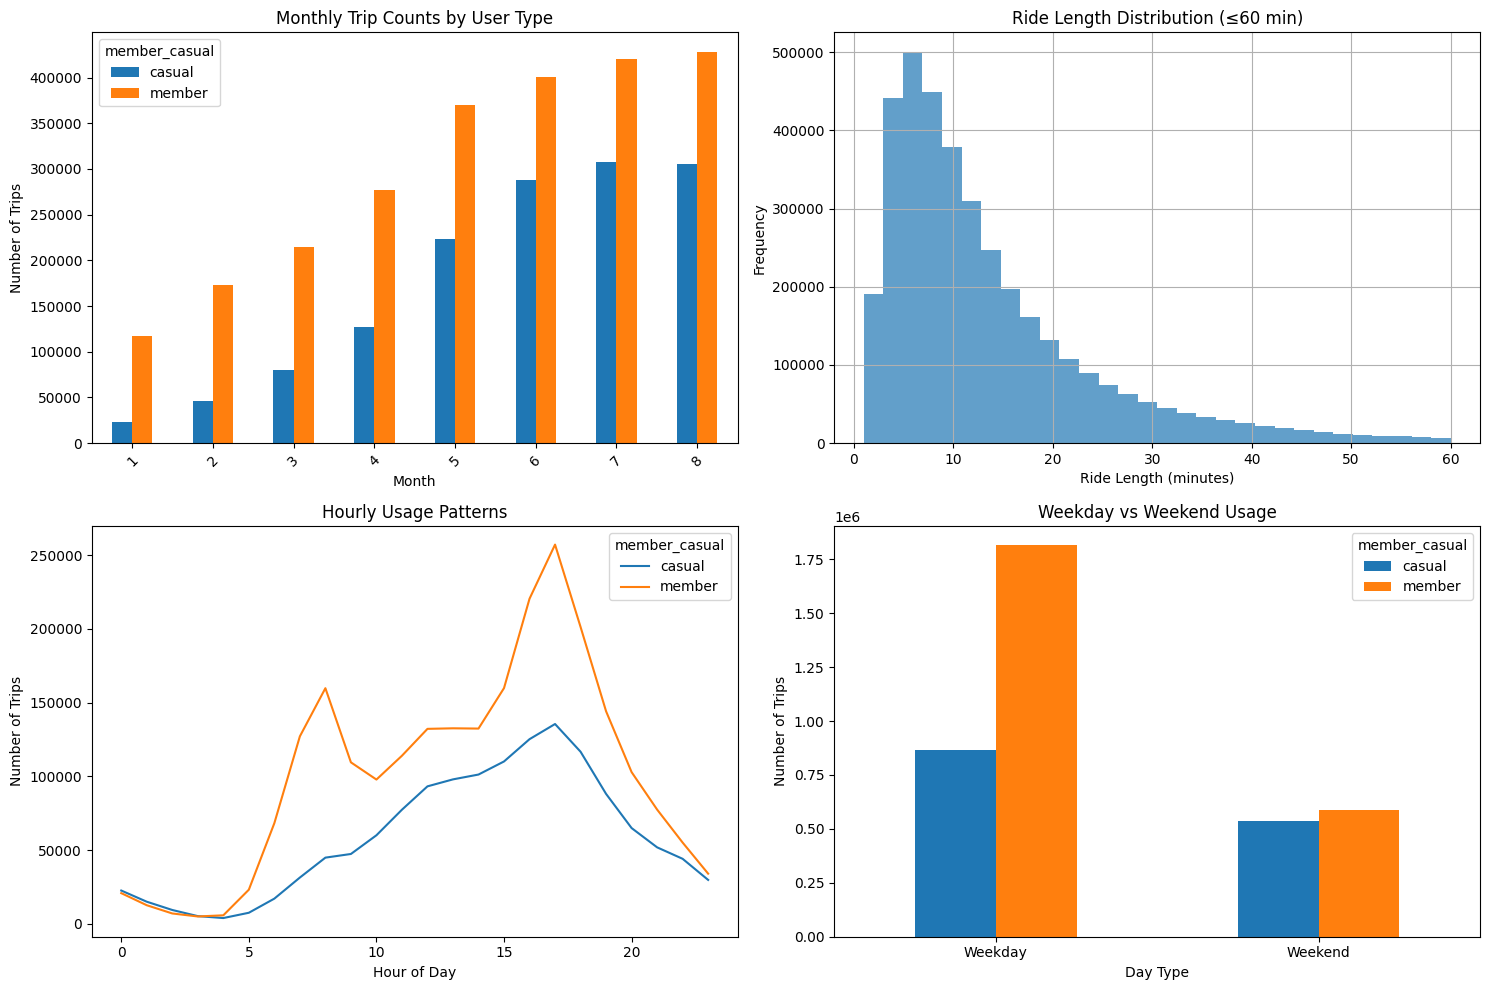

✅ Data verification plots complete!
🎯 Dataset ready for comprehensive analysis!

🚴‍♂️ CYCLISTIC DATA PROCESSING COMPLETE! 🚴‍♀️


In [10]:
# =============================================================================
# 8. QUICK VISUALIZATION FOR VERIFICATION
# =============================================================================

if not df_complete.empty:
    print("\n📊 QUICK DATA VERIFICATION PLOTS")
    print("-" * 50)

    # Create plots to verify data quality
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Monthly trip counts
    monthly_data = df_complete.groupby(['month', 'member_casual']).size().unstack()
    monthly_data.plot(kind='bar', ax=axes[0,0], title='Monthly Trip Counts by User Type')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Number of Trips')
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Ride length distribution
    df_complete[df_complete['ride_length_minutes'] <= 60]['ride_length_minutes'].hist(
        bins=30, ax=axes[0,1], alpha=0.7)
    axes[0,1].set_title('Ride Length Distribution (≤60 min)')
    axes[0,1].set_xlabel('Ride Length (minutes)')
    axes[0,1].set_ylabel('Frequency')

    # 3. Hourly usage patterns
    hourly_data = df_complete.groupby(['hour', 'member_casual']).size().unstack()
    hourly_data.plot(ax=axes[1,0], title='Hourly Usage Patterns')
    axes[1,0].set_xlabel('Hour of Day')
    axes[1,0].set_ylabel('Number of Trips')

    # 4. Weekend vs weekday
    weekend_data = df_complete.groupby(['is_weekend', 'member_casual']).size().unstack()
    weekend_data.index = ['Weekday', 'Weekend']
    weekend_data.plot(kind='bar', ax=axes[1,1], title='Weekday vs Weekend Usage')
    axes[1,1].set_xlabel('Day Type')
    axes[1,1].set_ylabel('Number of Trips')
    axes[1,1].tick_params(axis='x', rotation=0)

    plt.tight_layout()
    plt.show()

    print("✅ Data verification plots complete!")
    print("🎯 Dataset ready for comprehensive analysis!")

print("\n🚴‍♂️ CYCLISTIC DATA PROCESSING COMPLETE! 🚴‍♀️")